In [2]:
import random
import pickle
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from torch import nn, optim, autograd
from sklearn.preprocessing import MinMaxScaler
from math import cos, pi
from datetime import datetime
from torch.nn.utils.parametrizations import spectral_norm

In [16]:
# Constants.
INPUT_LAYER_DIM = 36
INPUT_LAYER_OUT = 256
SECOND_LAYER_OUT = 512
THIRD_LAYER_OUT = 1024
FOURTH_LAYER_OUT = 512
FIFTH_LAYER_OUT = 256
OUTPUT_LAYER_OUT = 36
T_MIN, T_MAX = 0, 36
BATCH_SIZE = 128
R_MIN, R_MAX = 0, 1
NUM_OF_SAMPLES = 2_000_000

DATA_LOADER_CONFIG = {
    "batch_size": BATCH_SIZE,
    "shuffle": True,
    "num_workers": 4
}

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(f"Device is {DEVICE}")

LOG_DIR = "/root/odev/logs/" + datetime.now().strftime("%d-%m-%Y-%H%M%S")
GENERATOR_MODEL_PATH = "/root/odev/generator_csprn/"
DISCRIMINATOR_MODEL_PATH = "/root/odev/discriminator_csprn/"
IMAGE_PATH = "/root/odev/images_csprn/"

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Init Mersenne-Twister.
mersenne_twister = random.Random(42)

Device is cuda:0


In [17]:
class Generator(nn.Module):

    def __init__(self):
        super(Generator, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(INPUT_LAYER_DIM, INPUT_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(INPUT_LAYER_OUT, SECOND_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(SECOND_LAYER_OUT, THIRD_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(THIRD_LAYER_OUT, FOURTH_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(FOURTH_LAYER_OUT, FIFTH_LAYER_OUT),
            nn.LeakyReLU(True),
            nn.Linear(FIFTH_LAYER_OUT, OUTPUT_LAYER_OUT),
            nn.LeakyReLU()
        )

    def forward(self, x):
        output = self.net(x)
        return output.reshape(-1)

In [18]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = nn.Sequential(
            # TODO: Burada kalmıştık.
            spectral_norm(nn.Linear(INPUT_LAYER_DIM, INPUT_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(INPUT_LAYER_OUT, SECOND_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(SECOND_LAYER_OUT, THIRD_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(THIRD_LAYER_OUT, FOURTH_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(FOURTH_LAYER_OUT, FIFTH_LAYER_OUT)),
            nn.LeakyReLU(True),
            spectral_norm(nn.Linear(FIFTH_LAYER_OUT, 1)),
            nn.Sigmoid(),
        )

    def forward(self, z):
        output = self.net(z)
        return output

In [19]:
def gradient_penalty(Disc, xr, xf):
    """
    :param D:
    :param xr: [b, 2]
    :param xf: [b, 2]
    :return:
    """
    # [b, 1]
    t = torch.rand(BATCH_SIZE, 1).cuda()
    # [b, 1] => [b, 2]  broadcasting so t is the same for x1 and x2
    t = t.expand_as(xr)
    # interpolation
    mid = (t * xr) + ((1 - t) * xf)
    # set it to require grad info
    mid.requires_grad_()
    pred = Disc(mid)
    grads = autograd.grad(
        outputs=pred,
        inputs=mid,
        grad_outputs=torch.ones_like(pred),
        create_graph=True,
        retain_graph=True,
        only_inputs=True)[0]

    # Yeni ekledim.
    grads = grads.reshape([xr.shape[0], -1])

    gp = torch.pow(grads.norm(2, dim=1) - 1, 2).mean()
    return gp

# Data

## Create dataset

In [7]:
import secrets
import struct

def secure_random_float():
    # Generate 4 random bytes (32 bits) using secrets.token_bytes
    random_bytes = secrets.token_bytes(4)
    
    # Convert the random bytes to a 32-bit unsigned integer
    random_integer = int.from_bytes(random_bytes, byteorder='big')
    
    # Convert the integer to a floating-point number between 0 and 1
    random_float = random_integer / (1 << 32)
    
    return random_float


def generate_secure_random_float_number():
    data = []
    for el in range(NUM_OF_SAMPLES):
        temp = []
        for t in range(T_MIN, T_MAX):
            temp.append(secure_random_float())
        data.append(torch.tensor(temp, dtype=torch.float32))
    return data

csprn_data = generate_secure_random_float_number()

## Load old data.

In [8]:
# Non-random number dataset.
with open("/root/odev/data/tensor_data_list.pkl", "rb") as f:
    random_number_data = pickle.load(f)


## Create dataset object.

In [9]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, number_data):
        self.data = number_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Select sample
        return self.data[index]


In [12]:
training_dataset = Dataset(random_number_data)
csprn_dataset = Dataset(csprn_data)

training_generator = torch.utils.data.DataLoader(
    training_dataset,
    **DATA_LOADER_CONFIG
)

mt_generator = torch.utils.data.DataLoader(
    csprn_dataset,
    **DATA_LOADER_CONFIG
)

# Data Visualization

In [13]:
def visualize_batch(data, title, epoch):
    data_stacked = np.column_stack(data)
    # plt.figure(figsize=(4,64))
    plt.imshow(data_stacked.T, cmap='gray', interpolation='nearest', vmin=0, vmax=1)
    plt.colorbar()
    
    path = IMAGE_PATH + f"{title}-" + f"{epoch}.png"
    plt.savefig(path)
    
    plt.show()

# Start Training

In [14]:
def save_model(epoch, gen_state_dict, gen_optim_state_dict, gen_loss, gen_path, disc_state_dict, disc_optim_state_dict, disc_loss, disc_path):
    # TODO: Refactor.
    try:
        # Save generator.
        genarator_path_base = gen_path + datetime.now().strftime("%d-%m-%Y-%H%M%S") + "/"
        generator_path = genarator_path_base + "generator.pth"
        
        if not os.path.exists(genarator_path_base):
            os.makedirs(genarator_path_base)
            print(f"Folder '{genarator_path_base}' created successfully.")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': gen_state_dict,
            'optimizer_state_dict': gen_optim_state_dict,
            'loss': gen_loss,
        }, generator_path)
    except Exception as e:
        print(e)
    # Save discriminator.
    try:
        discriminator_path_base = disc_path + datetime.now().strftime("%d-%m-%Y-%H%M%S") + "/"
        discriminator_path = discriminator_path_base + "discriminator.pth"
        
        if not os.path.exists(discriminator_path_base):
            os.makedirs(discriminator_path_base)
            print(f"Folder '{discriminator_path_base}' created successfully.")
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': disc_state_dict,
            'optimizer_state_dict': disc_optim_state_dict,
            'loss': disc_loss,
        }, discriminator_path)
        
    except Exception as e:
        print(e)


Iteration: 2771
Iteration: 2772
Iteration: 2773
Iteration: 2774
Iteration: 2775
Iteration: 2776
Iteration: 2777
Iteration: 2778
Iteration: 2779
Iteration: 2780
Iteration: 2781
Iteration: 2782
Iteration: 2783
Iteration: 2784
Iteration: 2785
Iteration: 2786
Iteration: 2787
Iteration: 2788
Iteration: 2789
Iteration: 2790
Iteration: 2791
Iteration: 2792
Iteration: 2793
Iteration: 2794
Iteration: 2795
Iteration: 2796
Iteration: 2797
Iteration: 2798
Iteration: 2799
Iteration: 2800
(1.1618925333023071, -0.50214684009552, 2800)
Pseudo random number:


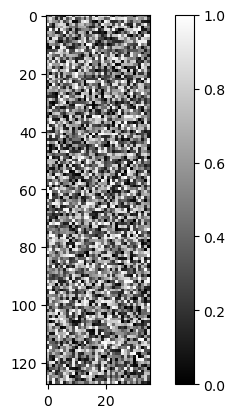

Generated random number:


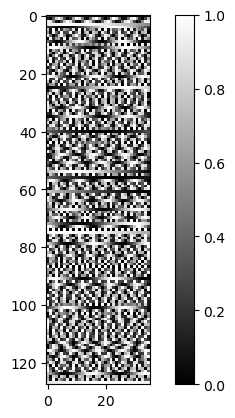

Iteration: 2801
Iteration: 2802
Iteration: 2803
Iteration: 2804
Iteration: 2805
Iteration: 2806


In [ ]:
def main():

    # Load models.
    Gen = Generator().to(DEVICE)
    Disc = Discriminator().to(DEVICE)

    # print("Generator")
    # print(Gen)
    # print("Discriminator")
    # print(Disc)

    optim_G = optim.Adam(Gen.parameters(), lr=0.0001, betas=(0.0, 0.9), weight_decay=2e-5)
    optim_D = optim.Adam(Disc.parameters(), lr=0.0001, betas=(0.0, 0.9), weight_decay=2e-5)
    # Visualize: viz.line([[0, 0]], [0], win='loss', opts=dict(title='loss', legend=['D', 'G']))
    for iteration in range(3001):
        # Discriminator training.
        for _ in range(5):  # train Discriminator 5 times.
            # 1.1 train on real data
            xr = next(enumerate(mt_generator))[1]
            xr = xr.to(torch.float32).to(DEVICE)
            # [b, 2] => [b, 1]
            predr = Disc(xr)
            lossr = -predr.mean()
            # 1.2 train on fake data
            # z=[b, 2]
            z = next(enumerate(training_generator))[1]
            z = z.to(torch.float32).to(DEVICE)
            xf = Gen(z).detach()  # gradient would be passed down
            xf = torch.reshape(xf, [BATCH_SIZE, 36])
            predf = Disc(xf)
            # min predf
            lossf = predf.mean()
            # 1.3 gradient penalty
            gp = gradient_penalty(Disc, xr, xf.detach())
            # aggregate all
            # loss_D = lossr + lossf + 0.2 * gp
            # Burayı yeni ekledim.
            x_out = torch.cat([predr, predf])
            loss_D = (lossr + lossf) + (gp * 2) + (x_out ** 10).mean() + .0001
            # optimize
            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()

        # 2. train G
        z = next(enumerate(training_generator))[1]
        z = z.to(torch.float32).to(DEVICE)
        xf = Gen(z)
        xf = torch.reshape(xf, [BATCH_SIZE, 36])
        predf = Disc(xf)
        # maximize predf.mean()
        loss_G = -predf.mean()
        # optimize
        optim_G.zero_grad()
        loss_G.backward()
        optim_G.step()
        
        print(f"Iteration: {iteration}")

        if iteration % 100 == 0:
            print((loss_D.item(), loss_G.item(), iteration))
            # viz.line([[loss_D.item(), loss_G.item()]], [epoch], win='loss', update='append')
            # print(loss_D.item(), loss_G.item())
            print("Pseudo random number:")
            visualize_batch(xr.cpu().numpy(), "Real Random number", iteration)
            print("Generated random number:")
            visualize_batch(z.cpu().numpy(), "Generated Random number", iteration)

        if iteration % 1000 == 0 and iteration > 0:
            save_model(
                iteration,
                Gen.state_dict(),
                optim_G.state_dict(),
                loss_G,
                GENERATOR_MODEL_PATH,
                Disc.state_dict(),
                optim_D.state_dict(),
                loss_D,
                DISCRIMINATOR_MODEL_PATH
            )

    save_model(
        iteration,
        Gen.state_dict(),
        optim_G.state_dict(),
        loss_G,
        GENERATOR_MODEL_PATH,
        Disc.state_dict(),
        optim_D.state_dict(),
        loss_D,
        DISCRIMINATOR_MODEL_PATH
    )
    
    return (
        Gen.state_dict(),
        optim_G.state_dict(),
        loss_G,
        GENERATOR_MODEL_PATH,
        Disc.state_dict(),
        optim_D.state_dict(),
        loss_D,
        DISCRIMINATOR_MODEL_PATH
    )

res = main()